In [1]:
# https://drive.google.com/file/d/1kc6XNqHZJg27KeBuoAoYj70_1rT92191/view?usp=sharing
# !gdown --id 1kc6XNqHZJg27KeBuoAoYj70_1rT92191

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191
From (redirected): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191&confirm=t&uuid=887bbe9f-71ee-4c71-b626-ad12623d076d
To: /content/vqa_coco_dataset.zip
100% 196M/196M [00:08<00:00, 21.9MB/s]


In [2]:
# !unzip -q vqa_coco_dataset.zip

## __1. Import libraries and set random seed__

In [ ]:
# !pip install timm==0.8.17.dev0
# !pip install torchtext==0.15.1
# !pip install torchvision==0.16.0
# !pip install torchaudio==2.1.0
# !pip install torch==2.1.0
# !pip install transformers==4.27.1

In [4]:
import torch
import torch.nn as nn
import torchtext
import os
import random
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## __2. Read dataset__

In [6]:

def load_data(data_path):
    """Load and process data from a text file."""
    data = []
    with open(data_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            temp = line.split("\t") # Split into image path and QA text
            qa = temp[1].split("?") # Split QA into question and answers
            image_path = temp[0][:-2] # Remove '#0' from image path

            # Extract the answer depending on the length of the split QA list
            answer = qa[2].strip() if len(qa) == 3 else qa[1].strip()

            data.append({
                "image_path": image_path,
                "question": qa[0] + "?",
                "answer": answer
            })
    return data

In [7]:
train_path = "vaq2.0.TrainImages.txt"
val_path = "vaq2.0.DevImages.txt"
test_path = "vaq2.0.TestImages.txt"

train_data = load_data(train_path)
val_data = load_data(val_path)
test_data = load_data(test_path)

len(train_data), len(val_data), len(test_data)

(7846, 1952, 2022)

## __3. Data Preprocessing__

In [8]:
eng = spacy.load("en_core_web_sm")

def get_tokens(data_iter):
    for sample in data_iter:
        question = sample['question']

        yield [token.text for token in eng.tokenizer(question)]


vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])

In [9]:
len(vocab)

1678

In [10]:
def tokenize(question, max_seq_len, vocab):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]

    return sequence

In [11]:
example_question = "Is this a picture of an apple?"
max_seq_len = 15

tokenize(example_question, max_seq_len, vocab)

[6, 5, 7, 16, 21, 75, 3, 4, 0, 0, 0, 0, 0, 0, 0]

In [12]:
def detokenize(sequence, vocab):
    idx_to_token = vocab.get_itos()

    tokens = [idx_to_token[idx] for idx in sequence if idx_to_token[idx] not in ['<pad>', '<sos>', '<eos>', '<unk>']]

    return " ".join(tokens)

In [13]:
classes = set([sample['answer'] for sample in train_data])
label2idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx2label = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx2label)

{0: 'no', 1: 'yes'}


## __4. Create Pytorch dataset__

In [14]:
class VQADataset(Dataset):
    def __init__(self, data, label2idx, max_seq_len=15, vocab=vocab, transform=None, img_dir='val2014-resised/'):
        self.data = data
        self.label2idx = label2idx
        self.max_seq_len = max_seq_len
        self.vocab = vocab
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Preprocess the image
        img_path = os.path.join(self.img_dir, self.data[index]["image_path"])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # Tokenize the question
        question = tokenize(self.data[index]["question"], self.max_seq_len, self.vocab)
        question = torch.tensor(question, dtype=torch.long)

        # Convert the label to an index
        label = self.label2idx[self.data[index]["answer"]]
        label = torch.tensor(label, dtype=torch.long)

        return img, question, label

In [15]:
data_transform = {
    'train': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.CenterCrop(size=180),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
}

In [16]:
train_dataset = VQADataset(
    train_data,
    label2idx=label2idx,
    transform=data_transform['train']
)
val_dataset = VQADataset(
    val_data,
    label2idx=label2idx,
    transform=data_transform['val']
)
test_dataset = VQADataset(
    test_data,
    label2idx=label2idx,
    transform=data_transform['val']
)

In [17]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## __5. Create VQA model__

In [18]:
class VQAModel(nn.Module):
    def __init__(self, n_classes, img_model_name, embedding_dim, n_layers=2, hidden_size=256, drop_prob=0.2):
        super(VQAModel, self).__init__()

        # Pre-trained image model
        self.image_encoder = timm.create_model(img_model_name, pretrained=True, num_classes=hidden_size)
        for param in self.image_encoder.parameters():
            param.requires_grad = True

        # Text embedding layer
        self.embedding = nn.Embedding(len(vocab), embedding_dim)

        # Bidirectional LSTM for text
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=drop_prob
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 3, hidden_size)
        self.dropout = nn.Dropout(drop_prob)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, img, text):
        # Image features
        img_features = self.image_encoder(img)

        # Text features
        text_emb = self.embedding(text)
        lstm_out, _ = self.lstm(text_emb)
        lstm_out = lstm_out[:, -1, :]

        # Concatenate image and text features
        combined = torch.cat((img_features, lstm_out), dim=1)

        # Fully connected layers
        x = self.fc1(combined)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [19]:
n_classes = len(classes)
img_model_name = "resnet18"
hidden_size = 256
n_layers = 2
embedding_dim = 128
drop_prob = 0.2
device = "cuda" if torch.cuda.is_available() else "cpu"

model = VQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embedding_dim=embedding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    drop_prob=drop_prob
).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [20]:
images, questions, labels = next(iter(train_loader))

model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    output = model(images, questions)
    print(output.shape)

torch.Size([256, 2])


## __6. Training__

In [21]:
def evaluate(moel, dataloader, criterion, device):
    correct, total = 0, 0
    losses = []

    model.eval()
    with torch.no_grad():
        for image, question, labels in dataloader:
            image, question, labels = image.to(device), question.to(device), labels.to(device)

            outputs = model(image, question)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1) # Get predicted label

            total += labels.size(0)
            correct += (predicted == labels).sum().item() # Count correct predictions

    loss = np.mean(losses)
    acc = correct / total

    return loss, acc

In [22]:
def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        total, correct = 0, 0
        batch_train_losses = []

        model.train()
        for images, questions, labels in train_loader:
            images, questions, labels = images.to(device), questions.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1) # Get predictions

            total += labels.size(0)
            correct += (predicted == labels).sum().item() # Count correct predictions

        train_loss = np.mean(batch_train_losses)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Step the learning rate scheduler
        scheduler.step()
    return train_losses, train_accs, val_losses, val_accs

In [23]:
lr = 1e-3
epochs = 50

scheduler_step_size = epochs * 0.8
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=0.1)

train_losses, train_accs, val_losses, val_accs = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

Epoch: 1/50 | Train Loss: 0.7011 | Train Acc: 0.5040 | Val Loss: 1.6047 | Val Acc: 0.4775
Epoch: 2/50 | Train Loss: 0.6926 | Train Acc: 0.5173 | Val Loss: 0.6901 | Val Acc: 0.5343
Epoch: 3/50 | Train Loss: 0.6927 | Train Acc: 0.5260 | Val Loss: 0.6936 | Val Acc: 0.5277
Epoch: 4/50 | Train Loss: 0.6916 | Train Acc: 0.5268 | Val Loss: 0.6908 | Val Acc: 0.5195
Epoch: 5/50 | Train Loss: 0.6906 | Train Acc: 0.5240 | Val Loss: 0.7100 | Val Acc: 0.4892
Epoch: 6/50 | Train Loss: 0.6880 | Train Acc: 0.5345 | Val Loss: 0.6959 | Val Acc: 0.5138
Epoch: 7/50 | Train Loss: 0.6906 | Train Acc: 0.5312 | Val Loss: 0.6895 | Val Acc: 0.5179
Epoch: 8/50 | Train Loss: 0.6919 | Train Acc: 0.5311 | Val Loss: 0.6933 | Val Acc: 0.5251
Epoch: 9/50 | Train Loss: 0.6877 | Train Acc: 0.5440 | Val Loss: 0.6954 | Val Acc: 0.5154
Epoch: 10/50 | Train Loss: 0.6861 | Train Acc: 0.5546 | Val Loss: 0.6954 | Val Acc: 0.4974
Epoch: 11/50 | Train Loss: 0.6883 | Train Acc: 0.5428 | Val Loss: 0.6928 | Val Acc: 0.5102
Epoch: 1

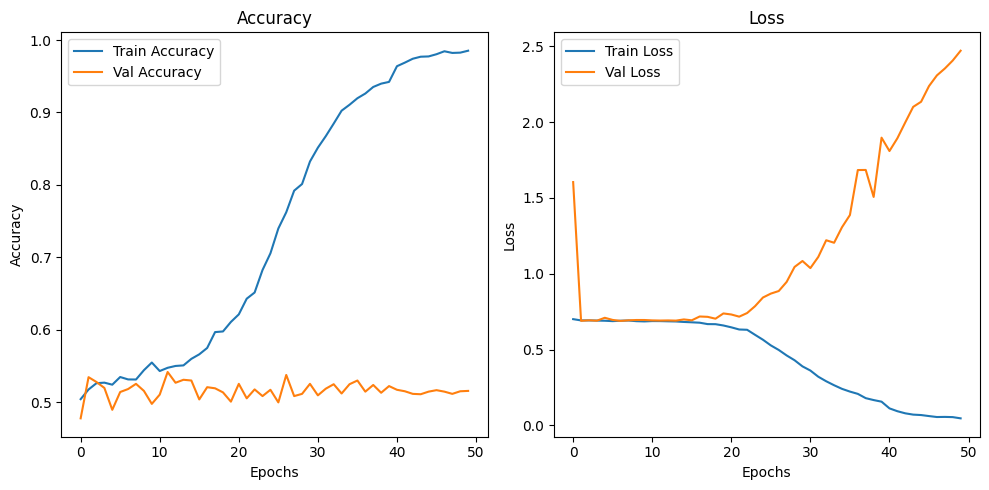

In [24]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

## __7. Evaluation__

In [25]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.5153688524590164
Test accuracy:  0.5202769535113749


## __8. Inference__

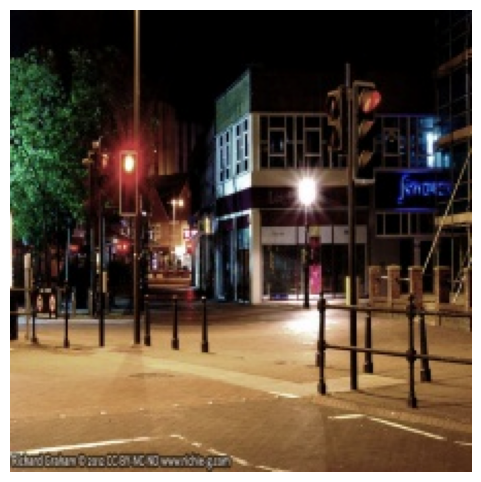

Question: Are there any any cars in this photo ?
Groundtruth: no
Predicted: no


In [36]:
idx = 32
img_name = test_data[idx]['image_path']
img_path = os.path.join('val2014-resised', img_name)
question = test_data[idx]['question']
label = test_data[idx]['answer']

max_seq_len = 15
question_processed = torch.tensor(tokenize(question, max_seq_len, vocab)).unsqueeze(0).to(device)

img = Image.open(img_path).convert("RGB")
img_processed = data_transform['val'](img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(img_processed, question_processed)
    pred = torch.argmax(output, dim=1).item()

reverse_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    transforms.ToPILImage()
])
image_vis = reverse_transform(img_processed.squeeze(0).cpu())

origin_quest = detokenize(question_processed.squeeze(0).cpu().tolist(), vocab)

plt.figure(figsize=(6, 6))
plt.imshow(image_vis)
plt.axis('off')
plt.show()

print(f'Question: {origin_quest}')
print(f'Groundtruth: {label}')
print(f'Predicted: {idx2label[pred]}')